In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import nltk
import re 
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, GlobalMaxPooling1D, SpatialDropout1D
from keras.callbacks import EarlyStopping

In [2]:
data=pd.read_csv('../input/twitter-entity-sentiment-analysis/twitter_training.csv', sep=',', names=['Tweet_ID','Entity','Sentiment','Tweet_content'])
data.head()

,Tweet_ID,Entity,Sentiment,Tweet_content
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [3]:
data.shape

(74682, 4)

In [4]:
data.Entity.unique()

array(['Borderlands', 'CallOfDutyBlackopsColdWar', 'Amazon', 'Overwatch',
       'Xbox(Xseries)', 'NBA2K', 'Dota2', 'PlayStation5(PS5)',
       'WorldOfCraft', 'CS-GO', 'Google', 'AssassinsCreed', 'ApexLegends',
       'LeagueOfLegends', 'Fortnite', 'Microsoft', 'Hearthstone',
       'Battlefield', 'PlayerUnknownsBattlegrounds(PUBG)', 'Verizon',
       'HomeDepot', 'FIFA', 'RedDeadRedemption(RDR)', 'CallOfDuty',
       'TomClancysRainbowSix', 'Facebook', 'GrandTheftAuto(GTA)',
       'MaddenNFL', 'johnson&johnson', 'Cyberpunk2077',
       'TomClancysGhostRecon', 'Nvidia'], dtype=object)

([<matplotlib.patches.Wedge at 0x72eb6c3ec510>,
 [Text(0.6414093669225578, 0.8936408809046303, 'Negative'),
  Text(-1.0260553442286633, 0.39649770564254155, 'Positive'),
  Text(-0.31734499213929374, -1.0532293937999033, 'Neutral'),
  Text(0.9398173765782871, -0.5716146417662045, 'Irrelevant')],
 [Text(0.3498596546850315, 0.4874404804934347, '30.2%'),
  Text(-0.5596665513974526, 0.21627147580502265, '27.9%'),
  Text(-0.17309726843961473, -0.5744887602544927, '24.5%'),
  Text(0.5126276599517929, -0.31178980459974787, '17.4%')])

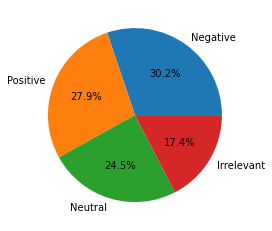

In [5]:
plt.pie(data.Sentiment.value_counts()
,labels=['Negative','Positive','Neutral','Irrelevant'],autopct='%1.1f%%')

In [6]:
data.Sentiment.value_counts()

Negative      22542
Positive      20832
Neutral       18318
Irrelevant    12990
Name: Sentiment, dtype: int64

In [7]:
# removing duplicate data
data.drop_duplicates(inplace=True)
print(data.duplicated().sum())

0


In [8]:
# removing null data
print(data.isnull().sum())
data.dropna(axis=0, inplace=True)

Tweet_ID           0
Entity             0
Sentiment          0
Tweet_content    326
dtype: int64


In [9]:
data.reset_index(inplace=True)
print(data.shape)
data.head()

(71656, 5)


,index,Tweet_ID,Entity,Sentiment,Tweet_content
0,0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [10]:
# text cleaning function
replace_list = {r"i'm": 'i am',
                r"'re": ' are',
                r"let’s": 'let us',
                r"'s":  ' is',
                r"'ve": ' have',
                r"can't": 'can not',
                r"cannot": 'can not',
                r"shan’t": 'shall not',
                r"n't": ' not',
                r"'d": ' would',
                r"'ll": ' will',
                r"'scuse": 'excuse',
                ',': ' ,',
                '.': ' .',
                '!': ' !',
                '?': ' ?',
                '\s+': ' '}
def clean_text(text):
    text = text.lower()
    for s in replace_list:
        text = text.replace(s, replace_list[s])
    text = ' '.join(text.split())
    return text

In [11]:
x = data['Tweet_content'].apply(lambda p: clean_text(p))

max Tweet_content len: 311


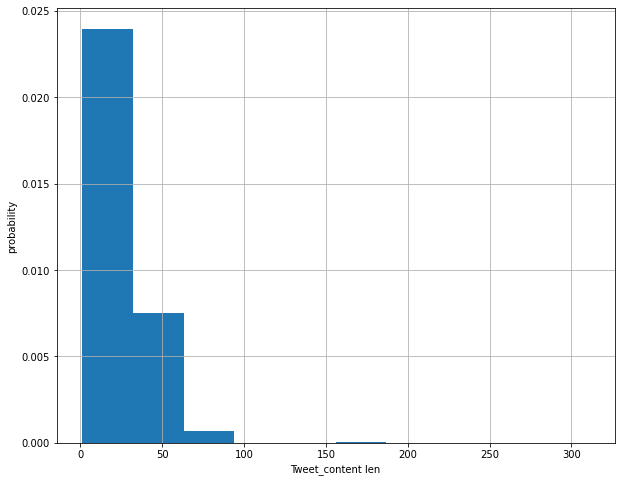

In [12]:
# analysing tweet lengths to find how many words to account for in our model
Tweet_content_len = x.apply(lambda p: len(p.split(' ')))
max_Tweet_content_len = Tweet_content_len.max()
print('max Tweet_content len: {0}'.format(max_Tweet_content_len))
plt.figure(figsize = (10, 8))
plt.hist(Tweet_content_len, density = True)
plt.xlabel('Tweet_content len')
plt.ylabel('probability')
plt.grid()

In [13]:
# data pre processing
import re 
REPLACE_WITH_SPACE = re.compile("(@)")
SPACE = " "
from nltk.corpus import stopwords
english_stop_words = stopwords.words('english')
from nltk.stem.porter import PorterStemmer
#1
def reviews(reviews):  
    reviews = [REPLACE_WITH_SPACE.sub(SPACE, line.lower()) for line in reviews]
    
    return reviews
#2
def remove_stop_words(corpus):
    removed_stop_words = []
    for review in corpus:
        removed_stop_words.append(
            ' '.join([word for word in review.split()  if word not in english_stop_words]))
    return removed_stop_words
#3
def get_stemmed_text(corpus):
    stemmer = PorterStemmer()

    return [' '.join([stemmer.stem(word) for word in review.split()]) for review in corpus]




In [14]:
y =data['Sentiment']

In [15]:
#1
reviewtweet = reviews(x)
#2
no_stop_words_tweet = remove_stop_words(reviewtweet)
#3
stemmed_reviews_tweet = get_stemmed_text(no_stop_words_tweet)

In [16]:
# string token vectorizer
max_words = 8000


tokenizer = Tokenizer(
    num_words = max_words,
    filters = '"#$%&()*+-/:;<=>@[\]^_`{|}~'
)
tokenizer.fit_on_texts(stemmed_reviews_tweet)
x = tokenizer.texts_to_sequences(stemmed_reviews_tweet)
x = pad_sequences(x, maxlen = 300)


In [17]:
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(y)

y = np.array(label_tokenizer.texts_to_sequences(y))


In [18]:
# model creation
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.8)

In [19]:
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim = max_words, output_dim = 128, input_length = 300))
model_lstm.add(SpatialDropout1D(0.3))
model_lstm.add(LSTM(128, dropout = 0.3, recurrent_dropout = 0.3))
model_lstm.add(Dense(128, activation = 'relu'))
model_lstm.add(Dropout(0.3))
model_lstm.add(Dense(5, activation = 'softmax'))
model_lstm.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='Adam',
    metrics=['accuracy']
)
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 128)          1024000   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 300, 128)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               131584    
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 645       
Total params: 1,172,741
Trainable params: 1,172,741
Non-trainable params: 0
______________________________________________

In [20]:
history = model_lstm.fit(
    x_train,
    y_train,
    validation_data=(x_test,y_test) , 
    epochs = 100,
    batch_size = 512,
    callbacks=EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
)


Epoch 1/100
112/112 [==============================] - 148s 1s/step - loss: 1.2923 - accuracy: 0.4094 - val_loss: 1.0417 - val_accuracy: 0.5706
Epoch 2/100
112/112 [==============================] - 145s 1s/step - loss: 0.9165 - accuracy: 0.6362 - val_loss: 0.7956 - val_accuracy: 0.6864
Epoch 3/100
112/112 [==============================] - 145s 1s/step - loss: 0.7138 - accuracy: 0.7276 - val_loss: 0.6973 - val_accuracy: 0.7298
Epoch 4/100
112/112 [==============================] - 143s 1s/step - loss: 0.6186 - accuracy: 0.7651 - val_loss: 0.6553 - val_accuracy: 0.7478
Epoch 5/100
112/112 [==============================] - 143s 1s/step - loss: 0.5533 - accuracy: 0.7893 - val_loss: 0.6116 - val_accuracy: 0.7651
Epoch 6/100
112/112 [==============================] - 144s 1s/step - loss: 0.5039 - accuracy: 0.8099 - val_loss: 0.5861 - val_accuracy: 0.7741
Epoch 7/100
112/112 [==============================] - 141s 1s/step - loss: 0.4646 - accuracy: 0.8227 - val_loss: 0.5715 - val_accuracy:

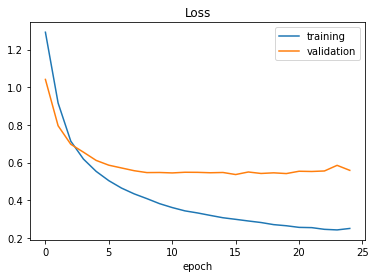

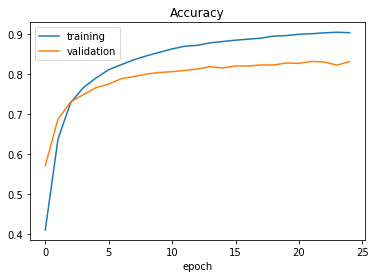

In [21]:
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','validation'])
plt.title('Loss')
plt.xlabel('epoch')
plt.figure(2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','validation'])
plt.title('Accuracy')
plt.xlabel('epoch')
plt.show()

In [22]:
model_lstm.evaluate(x_test, y_test)

448/448 [==============================] - 30s 66ms/step - loss: 0.5528 - accuracy: 0.8308


[0.5527632832527161, 0.8307982087135315]